## EXPLORATION 8. 뉴스 요약봇 만들기

#### □ 텍스트 요약(Text Summarization)이란?
- 긴 길이의 문서(Document) 원문을 핵심 주제만으로 구성된 짧은 요약(Summary) 문장들로 변환하는 것
- 요약 전후에 정보 손실 발생이 최소화되어야 한다

#### □ 추출적 요약
- 단어 그대로 원문에서 핵심 문장들을 추출해서 요약하는 방식
- 그러나 원문에서 추출된 핵심 문장들의 연결이 자연스럽지 않을 수 있다.

#### □ 추상적 요약
- 원문으로부터 내용이 요약된 새로운 문장을 생성해내는 것
- 자연어 처리 분야 중 자연어 생성(Natural Language Generation, NLG)의 영역
- 원문을 구성하는 문장 중 어느 것이 요약문에 들어갈 핵심문장인지를 판별한다는 점에서 문장 분류(Text Classification) 문제로 볼 수 있을 것

-----------------------------------------------------------------------------

### > 데이터 준비

> - 뉴스 기사 데이터(news_summary_more.csv) 사용
> - 아래의 코드로 데이터 다운로드

In [1]:
# 필요한 모듈 import
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
50922,WeÃ¢ÂÂll be profitable before 2022: Uber CEO...,Uber CEO Dara Khosrowshahi has said the startu...
86893,Russia and Ukraine engage in Twitter war,The official Twitter accounts of Ukraine and R...
94918,Zeenat Aman debuts in web series with Love Lif...,Veteran actress Zeenat Aman is making her debu...
70926,Malayalam actress slammed for eating meat duri...,Malayalam actress Surabhi Lakshmi has been sla...
30030,Ex-Infosys CEO Vishal Sikka earned about Ã¢ÂÂ...,"Former Infosys CEO Vishal Sikka, who quit the ..."
23439,RBI hikes repo rate by 25 bps for second time ...,The RBI's monetary policy committee in its thi...
13023,Plastic waste piling in Japan post China impor...,Japan on Thursday said its plastic waste was p...
25978,Infosys-made analytics help find GST defaulter...,"Bihar Deputy CM and GST Council member, Sushil..."
72959,Italian hotel has beds that can be rolled out ...,"An Italian hotel allows guests to sleep on ""wh..."
34291,Nothing going on: Chahal on rumours of marriag...,Reacting to media reports of his rumoured wedd...


### > 데이터 전처리

> 데이터 정리

In [5]:
# 중복 샘플 유무 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿈
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [7]:
# 데이터에 Null 값이 있는지 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [8]:
# 텍스트 정규화와 불용어 제거
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [9]:
# NLTK 에서 제공하는 불용어 리스트를 참조해 샘플에서 불용어 제거

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [10]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
# 전처리 전, 후 결과 확인
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


In [13]:
# 훈련 데이터 전체에 대한 전처리 수행 - 1.text 전처리

clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [17]:
# 훈련 데이터 전체에 대한 전처리 수행 - 2. headlines 전처리
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [18]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [19]:
data.isnull().sum() #Null값 확인

headlines    0
text         0
dtype: int64

> 훈련데이터와 테스트데이터 분리

text 의 최소 길이 : 1
text 의 최대 길이 : 60
text 의 평균 길이 : 35.09968483123221
headlines 의 최소 길이 : 1
headlines 의 최대 길이 : 16
headlines 의 평균 길이 : 9.299532330215534


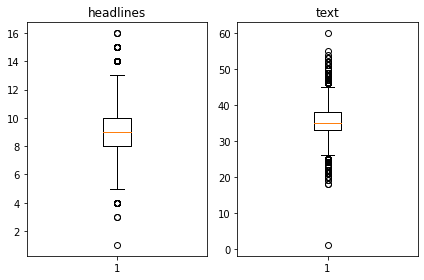

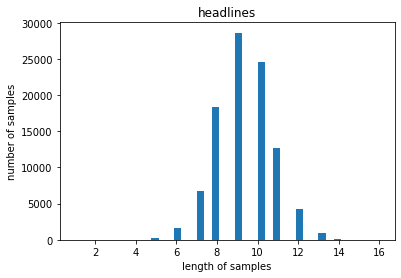

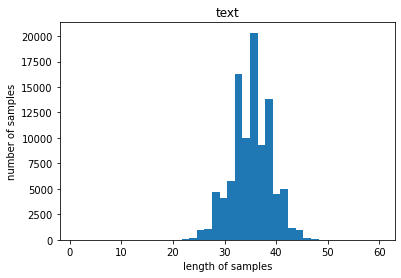

In [20]:
# 샘플의 최대길이 정하기
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('text 의 최소 길이 : {}'.format(np.min(text_len)))
print('text 의 최대 길이 : {}'.format(np.max(text_len)))
print('text 의 평균 길이 : {}'.format(np.mean(text_len)))
print('headlines 의 최소 길이 : {}'.format(np.min(headlines_len)))
print('headlines 의 최대 길이 : {}'.format(np.max(headlines_len)))
print('headlines 의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [28]:
text_max_len = 50
headlines_max_len =15

In [29]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [30]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 15 이하인 샘플의 비율: 0.9999694997966653


In [31]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98343


In [32]:
# 요약 데이터에는 시작토큰과 종료토큰 추가

data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [33]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장 

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [34]:
# 훈련데이터와 테스트데이터 분리
encoder_input_train, encoder_input_test, decoder_input_train, decoder_input_test, decoder_target_train, decoder_target_test = train_test_split(encoder_input,
                                                                                                                                               decoder_input,
                                                                                                                                               decoder_target,
                                                                                                                                               test_size=0.2,                                   
                                                                                                                                               random_state=34)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78674
훈련 레이블의 개수 : 78674
테스트 데이터의 개수 : 19669
테스트 레이블의 개수 : 19669


> 정수 인코딩

In [35]:
# Keras의 토크나이저를 사용하여 입력된 훈련 데이터로부터 단어 집합 생성
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

- src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있음
- 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

In [36]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69608
등장 빈도가 6번 이하인 희귀 단어의 수: 47436
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22172
단어 집합에서 희귀 단어의 비율: 68.14733938627744
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.492321499583859


In [37]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [38]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[0])

[450, 1723, 11899, 10252, 192, 7, 540, 514, 1676, 2011, 263, 87, 93, 2702, 329, 141, 3, 13, 287, 1090, 540, 402, 263, 87, 580, 3078, 1629, 11, 8015, 1912, 1227, 1912, 4956, 231, 618, 209, 1629, 263, 87, 329, 141]


> headlines 데이터에 대해서도 동일한 작업 수행

In [39]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [40]:
threshold = 7
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30126
등장 빈도가 6번 이하인 희귀 단어의 수: 20643
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9483
단어 집합에서 희귀 단어의 비율: 68.52220673172674
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.3495337205729365


In [41]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[0])
print('target')
print('decoder ',decoder_target_train[0])

input
input  [1, 56, 35, 4, 641, 3, 1343, 295, 4, 280, 290]
target
decoder  [56, 35, 4, 641, 3, 1343, 295, 4, 280, 290, 2]


In [42]:
# 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장, 이 샘플들은 모두 삭제
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 78674
훈련 레이블의 개수 : 78674
테스트 데이터의 개수 : 19668
테스트 레이블의 개수 : 19668


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [43]:
# 패딩하기
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

### > 모델 설계

In [45]:
# 우선 함수형 API를 이용해서 인코더를 설계
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [46]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [47]:
# 디코더의 출력층 설계
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [48]:
# 어텐션 메커니즘

from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### > 모델훈련

In [49]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 227s 711ms/step - loss: 4.4769 - val_loss: 4.1103
Epoch 2/50
308/308 [==============================] - 218s 707ms/step - loss: 3.9905 - val_loss: 3.8158
Epoch 3/50
308/308 [==============================] - 218s 709ms/step - loss: 3.7080 - val_loss: 3.6050
Epoch 4/50
308/308 [==============================] - 218s 708ms/step - loss: 3.4978 - val_loss: 3.4477
Epoch 5/50
308/308 [==============================] - 217s 705ms/step - loss: 3.3371 - val_loss: 3.3362
Epoch 6/50
308/308 [==============================] - 216s 702ms/step - loss: 3.2054 - val_loss: 3.2389
Epoch 7/50
308/308 [==============================] - 216s 703ms/step - loss: 3.0930 - val_loss: 3.1705
Epoch 8/50
308/308 [==============================] - 216s 703ms/step - loss: 2.9943 - val_loss: 3.1189
Epoch 9/50
308/308 [==============================] - 222s 719ms/step - loss: 2.9089 - val_loss: 3.0699
Epoch 10/50
308/308 [==============================] - 222s 720m

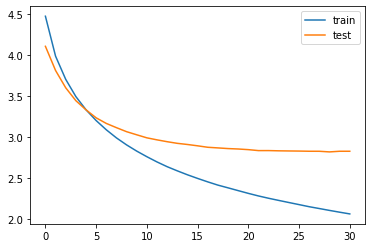

In [50]:
# 훈련데이터의 손실과 검증데이터의 손실이 줄어드는 과정을 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### > 인퍼런스 모델 구현

In [51]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [53]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [56]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [57]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### > 모델 테스트

In [58]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [59]:
# 테스트데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : applications public outdoor events mumbai cleared within hours brihanmumbai municipal corporation thursday introduced single window clearance system processing event permissions earlier applicant would visit four different departments clearances one approach respective ward file application online 
실제 요약 : public events in mumbai to get permit within hrs 
예측 요약 :  mumbai civic body to allow doctors to check alcohol from


원문 : passengers new york subway train gave student graduation ceremony missed high school graduation due nearly three hour train delay passenger presented student marco diploma cell phone another played green day graduation song time life hugged several passengers ceremony 
실제 요약 : commuters hold for student after hr train delay 
예측 요약 :  passenger who saved from train to be beaten up by


원문 : uber cab driver arrested chandigarh allegedly harassing woman passenger posing friend sending obscene messages got number earlier booked cab realising friend woman asked m

예측 요약 :  ganga to get clean chit for faulty ganga


원문 : department warned people indulging cash transactions lakh saying receiver pay equal amount penalty also advised people knowledge dealings tip department via email restriction applicable receipt government banking company post office savings bank co operative bank 
실제 요약 : penalty for receiving cash over lakh warns dept 
예측 요약 :  lakh people money to pay lakh money to lakh people


원문 : residents south delhi soon allotted two fixed parking spots per house issued permit stickers part project decongest delhi houses two cars park extra vehicles paid parking spots make arrangement vehicles towed parked designated spaces 
실제 요약 : fixed parking per home to be in delhi 
예측 요약 :  delhi parking to be built in parking parking


원문 : sharma formerly known bobby darling recently registered fir husband sharma grounds domestic violence unnatural sex said threatened get killed would kill prove natural death added bobby also sent mails prime mini

예측 요약 :  we have no one of the finance minister on jaitley


원문 : day assuming office pakistan prime minister imran khan arrived work sunday post morning workout wearing pictures shared khan official facebook page caption holiday country run seen carrying notebook group men 
실제 요약 : pakistan pm reaches office on sunday post morning workout 
예측 요약 :  pak pm imran khan trolled for sharing pics with pak pm imran khan


원문 : former australian pacer mitchell johnson stated tweet suspensions three players involved ball tampering scandal steve smith david warner cameron bancroft stay contest bans pacer response tweet stated bans smith warner could reduced 
실제 요약 : bans on smith warner bancroft should stay ex aus pacer 
예측 요약 :  david warner calls for australian cricket team


원문 : several fans demanded indian citizenship rashid khan year old afghanistan srh spinner said proud afghan stay country saturday afghanistan president ashraf ghani tweeted indian prime minister narendra modi jokingly s

### > 추출적 요약

In [60]:
# 패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공

from summa.summarizer import summarize
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [61]:
data.sample(10)

,headlines,text
67317,Army soldier martyred in ceasefire violation b...,An Army jawan was martyred on Tuesday when Pak...
8508,Facebook denies disbanding 'war room' 2 months...,Facebook has denied reports claiming the elect...
96398,Spanish court to probe 'state terrorism' by Sy...,A Spanish court will investigate allegations t...
69689,Japan releases postage stamps on Indian yoga e...,Japanese postal department has released postag...
80435,AIIMS docs to try separating twins joined at t...,Doctors at the All India Institute of Medical ...
66069,PM Modi will give every Gujarati a house on mo...,Accusing Prime Minister Narendra Modi of 'sell...
23602,WhatsApp launches 4-person group video calling,WhatsApp has officially released its group cal...
23284,"Paying maid less than Ã¢ÂÂ¹6,836/month may la...",The Tamil Nadu government has issued a notific...
56746,Healthcare startup DocsApp raises $7.2 mn in S...,Bengaluru-based online medical consultation st...
53642,"Guests can stay inside a bus with 5 beds, kitc...",Guests can stay inside a retired double-decker...


In [64]:
data['headlines_predict'] = data['text'].apply(lambda x: summarize(x, ratio=0.5))

In [65]:
data.sample(10)

,headlines,text,headlines_predict
3923,"In 2019, it will be 'janta' vs 'gathbandhan': ...",Prime Minister Narendra Modi on Tuesday said t...,Prime Minister Narendra Modi on Tuesday said t...
79333,Snapchat hires team to prevent rivals from ste...,Snapchat has acquired Swiss startup Strong.Cod...,"In May, Snapchat CEO Evan Spiegel said, ""Peopl..."
75999,"Shark travels 5,500 km in 200 days starting fr...",The migratory path of a female whale shark had...,The migratory path of a female whale shark had...
26208,HC pulls up IAF for confining officer to psych...,The Delhi High Court on Thursday pulled up the...,The Delhi High Court on Thursday pulled up the...
39668,Armaan begging me to return: Girlfriend after ...,Armaan Kohli's live-in girlfriend Neeru Randha...,Armaan Kohli's live-in girlfriend Neeru Randha...
82312,Chunky Pandey's daughter in Student of the Yea...,"According to reports, actor Chunky Pandey's da...","According to reports, actor Chunky Pandey's da..."
79797,Nepotism remark at IIFA 2017 was just a joke: ...,Saif Ali Khan has said that the remark on nepo...,Saif Ali Khan has said that the remark on nepo...
51400,Dutch cops to 'undress' youths wearing unaffor...,Police in the Netherlands' Rotterdam will iden...,Police in the Netherlands' Rotterdam will iden...
74575,Death toll in Gorakhpur's BRD Medical College ...,The death toll in Gorakhpur's BRD Medical Coll...,The death toll in Gorakhpur's BRD Medical Coll...
62970,I'll commit suicide if Twitter won't restore m...,Self-styled critic Kamaal R Khan has threatene...,Self-styled critic Kamaal R Khan has threatene...


In [66]:
for i in range(50, 100):
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("예측 요약 :", data['headlines_predict'][i])
    print("\n")

원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
실제 요약 : Yashwant Sinha demands probe into alleged fund diversion by DHFL
예측 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the seventh straight

### > 회고

- 추상적 요약 부분을 보면, 예측 요약이 일부 단어로 끊어서 보면 유사성을 가지나, 뉴스기사의 요약으로 사용하기에는 무리가 있다. 느낌만 어색하면 괜찮은데, 중심 내용 자체를 잡아내지 못하는 것 같아. 다른 샘플도 다 비교해봤는데, 최소 어색한 느낌이거나 완전히 다른 느낌으로 요약아닌 요약을 해버린다.

- 추출적 요약 부분은 잘 모르겠어서 구글링을해서 코드를 가져왔는데, 결과적으로는 추상적 요약보다는 추출적 요약이 조금 더 전체 내용면에서 우수한 성능이라고 생각된다.